# INFORMAÇÕES IMPORTANTES:

## Dependências

## Especificações da Pesquisa

- Horizonte de previsão: 30 min, 1 hora, 3 horas


# Utilização de rede neural recorrente LSTM para previsões intradiárias do mercado de ações. 

## Base de Dados:

In [15]:
import pandas as pd
import tensorflow as tf
#-----------------------------------------------------------
# Base de dados de 2019(antes da pandemia) e Base da ação de 2021(durante a pandemia)
# BPAC11, (BTG PACTUAL), ITUB4 (ITAÚ), BBDC4 (BRADESCO)
#-----------------------------------------------------------



#-----------------------------------------------------------
#Lendo o arquivo em csv
#-----------------------------------------------------------
df = pd.read_csv('/home/bene/MachineLearning/TCC/Base de Dados/BPAC_30m_2019.csv') 
#df = pd.read_csv('/home/bene/MachineLearning/TCC/Base de Dados/dados_teste.csv') 
df.head()

#print(df)
#df.info()

time    open    high     low   close  Volume
0  2019-01-02T10:00:00-02:00  5.9125  5.9375  5.9125  5.9300    7600
1  2019-01-02T10:30:00-02:00  5.9300  5.9700  5.9200  5.9525   46800
2  2019-01-02T11:00:00-02:00  5.9575  5.9925  5.9400  5.9800   52800
3  2019-01-02T11:30:00-02:00  5.9875  6.0050  5.9825  5.9900   57200
4  2019-01-02T12:00:00-02:00  5.9950  6.0350  5.9900  6.0175   60400

In [16]:
#-----------------------------------------------------------
#Para mudar o index, utilizei a fonte abaixo
# Fonte: https://www.delftstack.com/pt/howto/python-pandas/pandas-remove-index/#remover-%25C3%25ADndice-de-um-pandas-dataframe-utilizando-o-m%25C3%25A9todo-set_index
#-----------------------------------------------------------

df = df.set_index('time') #Mudando o index para o date
#print(df.index)

#-----------------------------------------------------------
#Sabe se mudou o index, porque com o df.info, ele não aparece como um dos parametros
#-----------------------------------------------------------
df.info()

#print(df)


<class 'pandas.core.frame.DataFrame'>
Index: 3917 entries, 2019-01-02T10:00:00-02:00 to 2019-12-30T17:30:00-03:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3917 non-null   float64
 1   high    3917 non-null   float64
 2   low     3917 non-null   float64
 3   close   3917 non-null   float64
 4   Volume  3917 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 183.6+ KB


## Gráficos:

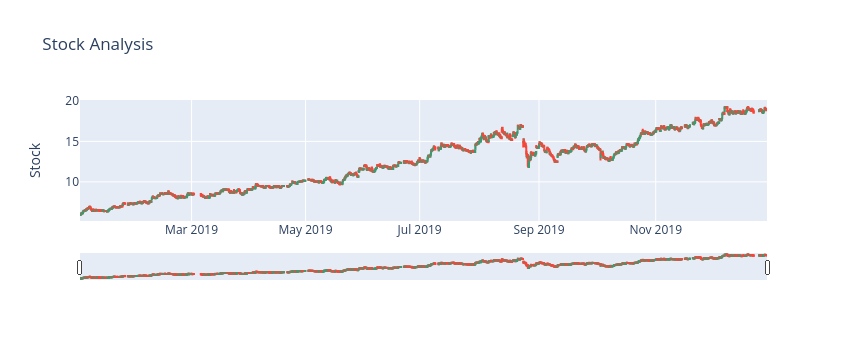

In [17]:
#-----------------------------------------------------------
#Transformando os dados em candlestick para melhorar a vizualização
#Fonte: https://python.plainenglish.io/a-simple-guide-to-plotly-for-plotting-financial-chart-54986c996682
#-----------------------------------------------------------

'''TENTAR COM UMA BASE MENOR '''
''' Talvez tenha ficado dessa maneira por ter muitos dados'''
import plotly.graph_objects as go
fig = go.Figure(go.Candlestick(x=df.index,
  open=df['open'],
  high=df['high'],
  low=df['low'],
  close=df['close']))


fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[15.5, 10], pattern="hour"),  # hide hours outside of 9.30am-4pm
            # dict(values=["2019-12-25", "2020-12-24"])  # hide holidays (Christmas and New Year's, etc)
        ]
)

fig.update_layout(
        title='Stock Analysis',
        yaxis_title='Stock'
)

fig.show()

#https://stackoverflow.com/questions/63780293/python-plotly-how-to-remove-datetime-gaps-in-candle-stick-chart
#https://plotly.com/python/ohlc-charts/

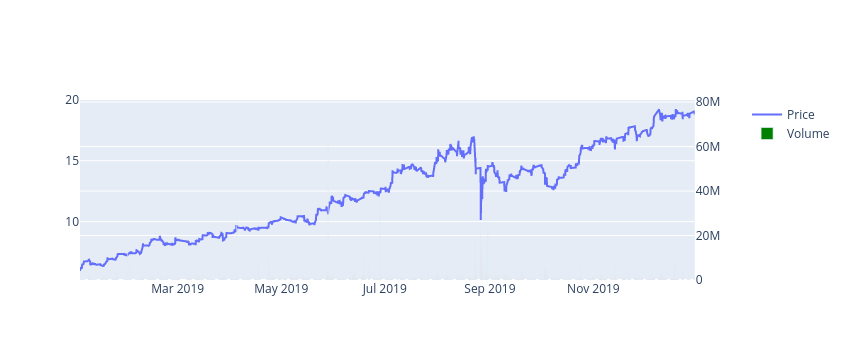

In [18]:
#-----------------------------------------------------------
# Gráfico de linha, na B3 contem  somente os preços de fechamento
# Fonte: https://pythoninoffice.com/draw-stock-chart-with-python/
#-----------------------------------------------------------

import plotly.graph_objects as go

#-----------------------------------------------------------
# Somente linhas
#-----------------------------------------------------------
#fig = go.Figure(data=go.Scatter(x=df.index,y=df['close'], mode='lines'))
#fig.show()

#-----------------------------------------------------------
# Somente linhas e pontos
#-----------------------------------------------------------
#fig = go.Figure(data=go.Scatter(x=df.index,y=df['close'], mode='lines+markers'))
#fig.show()


from plotly.subplots import make_subplots
#-----------------------------------------------------------
# Neste momento, as barras de volume têm todas a mesma cor. 
#Podemos usar cores diferentes para distinguir entre um dia de alta ou de 
#baixa – verde para dias de alta e vermelho para dias de baixa.
#Para fazer isso, basta calcular a mudança diária (positiva ou negativa) 
#e inserir uma coluna de cores em nosso dataframe
#-----------------------------------------------------------
df['diff'] = df['close'] - df['open']
df.loc[df['diff']>=0, 'color'] = 'green'
df.loc[df['diff']<0, 'color'] = 'red'

fig = make_subplots(specs=[[{"secondary_y": True}]])

#-----------------------------------------------------------
# Apesar do preço de fechamento do ativo ser o item mais avaliado, 
# o gráfico de linhas também permite visualizar valores de abertura, 
# mínimas ou máximas de forma separada.
#-----------------------------------------------------------

#-----------------------------------------------------------
# O gráfico de linhas
#-----------------------------------------------------------
fig.add_trace(go.Scatter(x=df.index,y=df['close'],name='Price'),secondary_y=False)

#-----------------------------------------------------------
# O gráfico de barras
#-----------------------------------------------------------
fig.add_trace(go.Bar(x=df.index,y=df['Volume'],name='Volume', marker={'color':df['color']}),secondary_y=True)
fig.show()


## Pré-processamento de dados:

In [19]:
#-----------------------------------------------------------
#1º Passo: Retirar valores nulos
#-----------------------------------------------------------

'''Valores nulos podem ser só considerados valores NaN ou valor 0?
Um valor 0 poderia causar problema para a previsão? '''
# https://insightlab.ufc.br/6-truques-do-pandas-para-impulsionar-sua-analise-de-dados
#Quando o conjunto de dados é grande, podemos contar o número de valores ausentes.
df.isnull().sum()
#print(df)

#https://medium.com/codex/simple-moving-average-and-exponentially-weighted-moving-average-with-pandas-57d4a457d363
#https://www.statology.org/exponential-moving-average-pandas/
#https://towardsdatascience.com/time-series-from-scratch-exponentially-weighted-moving-averages-ewma-theory-and-implementation-607661d574fe



open      0
high      0
low       0
close     0
Volume    0
diff      0
color     0
dtype: int64

## Normalização

time
2019-01-02T10:30:00-02:00    0.003787
2019-01-02T11:00:00-02:00    0.004609
2019-01-02T11:30:00-02:00    0.001671
2019-01-02T12:00:00-02:00    0.004580
2019-01-02T12:30:00-02:00    0.011155
                               ...   
2019-12-30T15:30:00-03:00    0.002649
2019-12-30T16:00:00-03:00    0.000132
2019-12-30T16:30:00-03:00    0.001850
2019-12-30T17:00:00-03:00   -0.000925
2019-12-30T17:30:00-03:00   -0.006098
Name: close, Length: 3916, dtype: float64


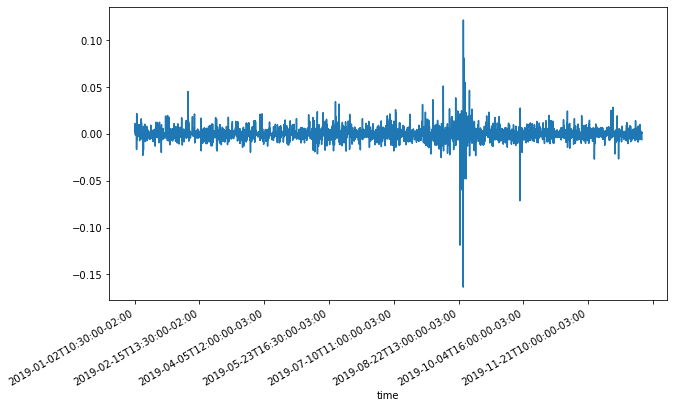

In [20]:
#-----------------------------------------------------------
# 2º Passo: Normalização da base (valores ruidosos) 
# Utilização do Log_return para preços de fechamento da ação
#-----------------------------------------------------------
import numpy as np
import pandas as pd

#-----------------------------------------------------------
# Os retornos de log são calculados de forma vetorizada (“sem loop” no nível do Python).
#-----------------------------------------------------------
rets = np.log(df['close'] / df['close'].shift(1))
#df['Returns'] = np.log(df['close'] / df['close'].shift())
#df.dropna(inplace=True)
#print(df['Returns'])


#-----------------------------------------------------------
# Verificar quantos valores ausentes existem
#-----------------------------------------------------------
rets.isnull().sum()

#-----------------------------------------------------------
# Um subconjunto dos dados é selecionado e os valores NaN (“não é um número”) são eliminados.
#-----------------------------------------------------------
rets.dropna(inplace=True)
print(rets)
#print(df['close'])

#-----------------------------------------------------------
# Plotar o gráfico
#-----------------------------------------------------------
rets.plot(subplots=True, figsize=(10, 6));

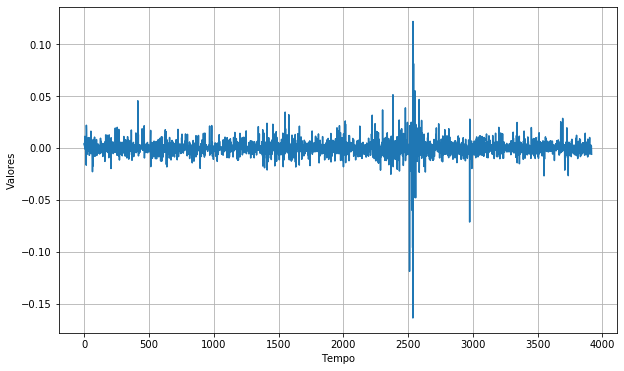

In [21]:
import numpy as np
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Construo um gráfico com os valores de Log_retorno e o Tempo de 0->3915 (Que seria o número de valores)
# existentes na base.
#-----------------------------------------------------------
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Tempo")
    plt.ylabel("Valores")
    plt.grid(True)

time_step = []
log_return = []
number = 0

for row in rets:
    log_return.append(float(row))
    number+=1
    time_step.append(int(number))


series = np.array(log_return)
time = np.array(time_step)

plt.figure(figsize=(10, 6))
plot_series(time, series)

## Separação em conjunto de treinamento e teste

Em seguida, você dividirá os dados acima em conjuntos de treinamento e validação. Você receberá os primeiros 1.000 pontos para treinamento, enquanto o restante é para validação.

In [22]:
#-----------------------------------------------------------
# Definir a separação entre conjunto de Treinamento e de Teste
#-----------------------------------------------------------
# Total = 3916 (len(rets))
# Treinamento = 2740
# Teste = 1176

split_time = 2740
time_train = time[:split_time]
x_train = series[:split_time]
print(x_train)

time_test = time[split_time:]
x_test = series[split_time:]
print(x_train)

[ 0.00378709  0.00460927  0.00167084 ...  0.00362319  0.00252845
 -0.00216685]
[ 0.00378709  0.00460927  0.00167084 ...  0.00362319  0.00252845
 -0.00216685]


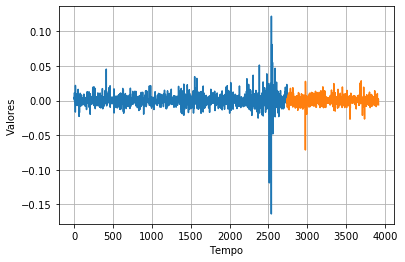

In [25]:
#-----------------------------------------------------------
# Plotar o gráfico de Treinamento
#-----------------------------------------------------------
plot_series(time_train, x_train)

#-----------------------------------------------------------
# Plotar o gráfico de Teste
#-----------------------------------------------------------
plot_series(time_test, x_test)


## Preparar recursos/features/entradas e os rótulos/labels/saida

### Preparar o Dataset(Dados de Log_return) todo

In [48]:
#-----------------------------------------------------------
# Transformar o Dataset em uma lista
#-----------------------------------------------------------
dataset = rets.values.tolist()
#print(dataset)


#-----------------------------------------------------------
# Com a ajuda de tf.data.Dataset.from_tensor_slices()method, podemos obter as 
# fatias de um array na forma de objetos usando tf.data.Dataset.from_tensor_slices()method.
# https://acervolima.com/tensorflow-tf-data-dataset-from_tensor_slices/
#-----------------------------------------------------------
dataset = tf.data.Dataset.from_tensor_slices(dataset)
#print(dataset)

#-----------------------------------------------------------
# Janela os dados, mas apenas pegue aqueles com o tamanho especificado. No exemplo abaixo,
# separa os dados de 5 em 5:
# [0.0037870863, 0.0046092686, 0.0016708442, 0.0045804786, 0.011154836] 
# Obs: O drop_remainder=True deixa os dados regularmente dimensionados. Mas o que isso quer dizer?
# Quer dizer que temos uma dimensão dessa maneira:
# 0 1 2 3 4 5
# 1 2 3 4 5 6
# 2 3 4 5 6 7
# ao invés de:
# 0 1 2 3 4 5
# 1 2 3 4 
# 1 2 
#-----------------------------------------------------------
dataset = dataset.window(size=5, shift=1, drop_remainder=True)

#-----------------------------------------------------------
# Printa na tela o janelamento anterior
#-----------------------------------------------------------
#for window_dataset in dataset:
  #print([item.numpy() for item in window_dataset])

    
#-----------------------------------------------------------
# Achate as janelas colocando seus elementos em um único lote:
# Exemplo: [0.00378709 0.00460927 0.00167084 0.00458048 0.01115484]
#-----------------------------------------------------------
dataset = dataset.flat_map(lambda window: window.batch(5))

#-----------------------------------------------------------
# Printa na tela o achatamento anterior
#-----------------------------------------------------------
#for window in dataset:
  #print(window.numpy())


#-----------------------------------------------------------
# Cria tuplas com recursos/features (os quatro primeiros elementos da janela) e rótulos/labels (último elemento)
#-----------------------------------------------------------
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

#-----------------------------------------------------------
# Printa na tela os recursos/features/entradas e os rótulos/labels/saida
#-----------------------------------------------------------
#for x,y in dataset:
    #print(x.numpy(), y.numpy())

    
#-----------------------------------------------------------
# Emabaralha os valores para não criar um vies (NÃO ACHO NECESSÁRIO POR ENQUANTO)
#-----------------------------------------------------------
#dataset = dataset.shuffle(buffer_size=10)


#-----------------------------------------------------------
# Cria lotes de janelas, ou seja, se definimos:
# dataset = dataset.batch(batch_size).prefetch(1)
# Onde batch_size = 2, quer dizer que será de blocos de 2 em 2, exemplo:
# x =  [[0.00378709 0.00460927 0.00167084 0.00458048] (entrada 1)
#      [0.00460927 0.00167084 0.00458048 0.01115484]] (entrada 2)
# y =  [[0.01115484] (saida 1)
#      [0.0094051 ]] (saida 2)
#-----------------------------------------------------------
dataset = dataset.batch(2).prefetch(1)

#-----------------------------------------------------------
# Printa na tela a configuração dos batches
#-----------------------------------------------------------
#for x,y in dataset:
    #print("x = ", x.numpy())
    #print("y = ", y.numpy())


### Preparar os dados de Treinamento

In [54]:
#-----------------------------------------------------------
# Parametros a serem usados na função de conjunto de dados janelado
#
# WINDOW_SIZE(int): Janela os dados, mas apenas pegue aqueles com o tamanho especificado.No exemplo abaixo,
# separa os dados de 4 em 4.
# BATCH_SIZE(int): Cria lotes de janelas, ou seja, se definimos batch_size = 2, quer dizer que será 
# de blocos de 2 em 2.
# Obs: O batch_size costuma ser: 32, 64, 128 (https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)
# SHUFFLE_BUFFER_SIZE(int): Emabaralha os valores para não criar um vies (NÃO ACHO NECESSÁRIO POR ENQUANTO)
#-----------------------------------------------------------

window_size = 4
batch_size = 32
#shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size):
#def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Gera janelas de conjunto de dados

    Args:
      series (array of float) - Contém os valores da série temporal de treinamento
      window_size (int) - o número de passos de tempo para a média
      batch_size (int) - o tamanho do lote
      shuffle_buffer(int) - tamanho do buffer a ser usado para o método shuffle

    Returns:
      dataset (TF Dataset) - Conjunto de dados de treinamento contendo janelas de tempo
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Embaralhe as janelas
    #dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

#-----------------------------------------------------------
# Gera o conjunto de dados de TREINAMENTO já com as dimensões previamente especificadas na função
#-----------------------------------------------------------
train_set = windowed_dataset(x_train, window_size, batch_size)
#train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#-----------------------------------------------------------
# Printa na tela a configuração  de todas as dimensões pré-definidas
#-----------------------------------------------------------
#for x,y in train_set:
    #print(x.numpy(), y.numpy())
    #print("x = ", x.numpy())
    #print("y = ", y.numpy())

https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_1_LSTM.ipynb

https://colab.research.google.com/github/BeneInfosec/MachineLearning/blob/main/Coursera_Sequences_Time%20_Series_and_Prediction/Semana_4_Licao_2_Sunspots.ipynb

https://sailajakarra.medium.com/lstm-for-time-series-predictions-cc68cc11ce4f
https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e 
https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
https://machinelearningmastery.com/use-timesteps-lstm-networks-time-series-forecasting/
https://humboldt-wi.github.io/blog/research/information_systems_1718/06financialtime-series/